In [1]:
import pandas as pd
import numpy as np
from random import sample
from sklearn import linear_model as sklm
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
%pylab inline


Bad key "back end" on line 1 in
/Users/bethevans/.matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


Populating the interactive namespace from numpy and matplotlib


/Users/bethevans/.virtualenvs/zoopy/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['sample']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
def separate_dates(dataframe, col1, col2):
    '''Function takes a dataframe and two column names. Function adds 
        an additional two columns to the dataframe with the year of the strain in YYYY form
        '''
    
    strain_1_labels = list(dataframe[col1])
    strain_2_labels = list(dataframe[col2])
    
    strain_1_dates = []
    strain_2_dates = []
    
    for label in strain_1_labels:
        date = int(list(label.split('/'))[-1])
        if date <60:
            date+=2000
        else:
            date+=1900
        strain_1_dates.append(date)
        
    for label2 in strain_2_labels:
        date = int(list(label2.split('/'))[-1])
        if date <60:
            date+=2000
        else:
            date+=1900
        strain_2_dates.append(date)
    
    dataframe['strain_1_dates'] = pd.Series(strain_1_dates, index=dataframe.index)
    dataframe['strain_2_dates'] = pd.Series(strain_2_dates, index=dataframe.index)

In [3]:
def print_full(x):
    pd.set_option('display.max_columns', len(x))
    print(x)
    pd.reset_option('display.max_columns')

In [4]:
file = open('data.csv')
df = pd.read_csv(file)
df = df.drop(0)
separate_dates(df, 'AG1', 'AG2')

In [5]:
#print_full(df)

In [6]:
def random_sample(dataframe):
    '''Function splits the dataframe into training and test data.
    Testsize should be a decimal e.g. 0.2 means 80% data = train; 20% data = test'''
    
    global unseen, dftest, Xtrain, Xtest, ytrain, ytest, Xtrain_noham, Xtrain_ham, Xtest_noham, Xtest_ham
    
    dftrain, dftest = train_test_split(dataframe, test_size = 0.2)
    Xtrain = dftrain.drop(['AG1', 'AG2', 'strain_1_dates', 'strain_2_dates'], axis = 1)
    Xtest = dftest.drop(['AG1', 'AG2', 'strain_1_dates', 'strain_2_dates'], axis = 1)
    
    #remove rows with unseen substitutions
    unseen = []
    for column in Xtrain.columns:
        if sum(Xtrain[column]) == 0:
            unseen.append(column)
    print(unseen)
    for item in unseen:
        Xtrain = Xtrain[Xtrain[item] != 1]
        Xtest_filtered = Xtest[Xtest[item] != 1]
    
    #create X and y training and test data - for both
    ytrain = Xtrain['AG-DIST']
    ytest = Xtest['AG-DIST']
    Xtrain = Xtrain.drop(['AG-DIST'], axis = 1)
    Xtest = Xtest.drop(['AG-DIST'], axis = 1)
    
    #create X training and test data - remove hamming distance
    Xtrain_noham = Xtrain.drop(['NUM-MUTATIONS'], axis = 1)
    Xtrain_ham = Xtrain['NUM-MUTATIONS']
    Xtest_noham = Xtest.drop(['NUM-MUTATIONS'], axis = 1)
    Xtest_ham = Xtest['NUM-MUTATIONS']

In [7]:
random_sample(df)

['IR145']


In [8]:
#run with both hamming distance and amino acid substitutions

both = sklm.Ridge(alpha=300)
both.fit(Xtrain, ytrain)
score = both.score(Xtest, ytest)
print(score)

0.649311931625


In [9]:
#creates two-column data frame of mutations and coefficient values
coef_df = pd.DataFrame(data = both.coef_, index = Xtrain.columns)

In [10]:
#optional codes to check data in dataframe is good

#print the head of the coef dataframe
#print(coef_df.head)

#print only the unseen items and their values from the coef dataframe - these should currently be 0.0
#print(coef_df.loc[coef_df.index.isin(unseen)])

In [11]:
#create dictionary with keys = substitutions, values = co-efficients
coef_dict = {}
for coef, subs in zip(both.coef_, Xtrain.columns):
    coef_dict[subs] = coef

#line to print out all key, value pairs for substitutions that occur at a particular position, e.g. '031' 
print([[key, value] for key, value in coef_dict.items() if '031' in key.lower()])

[['DN031', -0.048689623176275981], ['NV031', -0.0018910627978449086]]


In [12]:
def average(unseen_item_list):
    '''This function takes the list of unseen items, and makes their coefficient
        values the average of all known amino acid substitutions at local positions'''
    positions = []
    averages_list = []
    updated_items = {}
    for item in unseen_item_list:
        position = item[2:5]
        positions.append(position)
        #local positions are defined as those +/- 1 around the desired position - this could be changed
        local_positions = [int(position)-2, int(position)-1, int(position), int(position)+1, int(position)+2]
        local_coefs = []
        for local_pos in local_positions:
            other_coefs_at_pos = [value for key, value in coef_dict.items() 
                                    if str(local_pos) in key.lower()]
            local_coefs += other_coefs_at_pos
        average = np.mean(local_coefs)
        updated_items.update({item: average})
        coef_df.loc[item] = average
    
    print(updated_items)

In [13]:
average(unseen)

{'IR145': 0.069580818475110884}


In [14]:
#line to check whether the coefficient values have been updated - they should now not be 0.0
print(coef_df.loc[(coef_df.index.isin(unseen))])

              0
IR145  0.069581


In [15]:
#in the model, update the coefficients so that they include the average values as above
both.coef_= coef_df[0]

In [16]:
#create a new dataframe with index = amino acid substitutions, data = coefficients (including updates ones)
new_coefs = pd.DataFrame(data = both.coef_, index = Xtrain.columns) 

In [17]:
#code to check whether dataframe of new coefs has been correctly updated - should be as above
print(new_coefs.loc[(new_coefs.index.isin(unseen))])

              0
IR145  0.069581


In [18]:
#run the model again, using the updated coefficient values. Is it better?
both.predict(Xtest)
print('new score is ', both.score(Xtest, ytest))
print('old score is ', score)

('new score is ', 0.64943058837551759)
('old score is ', 0.64931193162454048)


Beth B - Putting all of this into a tidier function

In [19]:
def modifycoefs(clf, unseen):
    coef_df = pd.DataFrame(data=clf.coef_, index = xtrain.columns)
    coef_dict = {}
    for coef, subs in zip(clf.coef_, xtrain.columns):
        coef_dict[subs] = coef
    positions = []
    averages_list = []
    updated_items = {}
    for item in unseen:
        position = item[2:5]
        positions.append(position)
        local_positions = [int(position)-1, int(position), int(position)+1]
        local_coefs = []
        for local_pos in local_positions:
            other_coefs_at_pos = [value for key, value in coef_dict.items() 
                                    if str(local_pos) in key.lower()]
            local_coefs += other_coefs_at_pos
        average = np.mean(local_coefs)
        updated_items.update({item: average})
        coef_df.loc[item] = average
    clf.coef_=coef_df[0]

In [20]:
#Must reshape data that is in single column format for use in linear regression below

Xtrain_ham = Xtrain_ham.reshape(-1,1)
Xtest_ham = Xtest_ham.reshape(-1,1)
ytrain = ytrain.reshape(-1, 1)
ytest = ytest.reshape(-1, 1)

In [21]:
#other bits of code you might want to use to check stuff

#print Xtrain_ham.shape
#print ytrain.shape
#print Xtest_ham.shape
#print ytest.shape

In [22]:
#run with hamming distance only
ham = sklm.LinearRegression()
ham.fit(Xtrain_ham, ytrain)
score = ham.score(Xtest_ham, ytest)
print(score)

0.221730818545


/Users/bethevans/.virtualenvs/zoopy/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [23]:
#run with amino acid substitutions only
aasub = sklm.LinearRegression()
aasub.fit(Xtrain_noham, ytrain)
score = aasub.score(Xtest_noham, ytest)
print(score)

-2.09946662987e+21


In [24]:
#other beth's error plot

def errorplot(clf, xtst):
    fig_size = [15, 6]
    plt.rcParams["figure.figsize"] = fig_size
    
    #Make a dataframe 'errors' to hold the ytest, predicted values, and errors, then sort by the error size
    errors = pd.DataFrame(data=ytest, columns =('AG-DIST',))
    errors['predicted'] = clf.predict(xtst)
    errors['error'] = errors['predicted'] - errors['AG-DIST']
    errors['date'] = dftest['strain_2_dates']
    errors = errors.sort_values('error')

    plt.figure(3)
    errors = errors.sort_values('date')
    
    #Add some random noise to the dates to avoid overplotting
    errors['jittered_dates'] = errors['date'] + np.random.uniform(-2, 2, len(ytest))
    
    plt.scatter(errors['jittered_dates'], errors['AG-DIST'], color = 'g', s=3, marker='o')
    plt.scatter(errors['jittered_dates'], errors['predicted'], color = 'b', s=3)
    plt.scatter(errors['jittered_dates'], errors['error'], color = 'r', s=3)
    plt.xlabel('Strain 2 dates')
    plt.ylabel('Antigenic distance')
    red_patch = mpatches.Patch(color='red', label='Error')
    green_patch = mpatches.Patch(color='green', label='True value')
    blue_patch = mpatches.Patch(color='blue', label='Predicted value')
    plt.legend(handles=[red_patch, green_patch, blue_patch])
    
    plt.figure(4)
    plt.hist(errors['error'], bins=30)
    plt.xlabel('error size')
    plt.ylabel('frequency')
    #plt.axvline(x=mean(errors['error']), color='r')

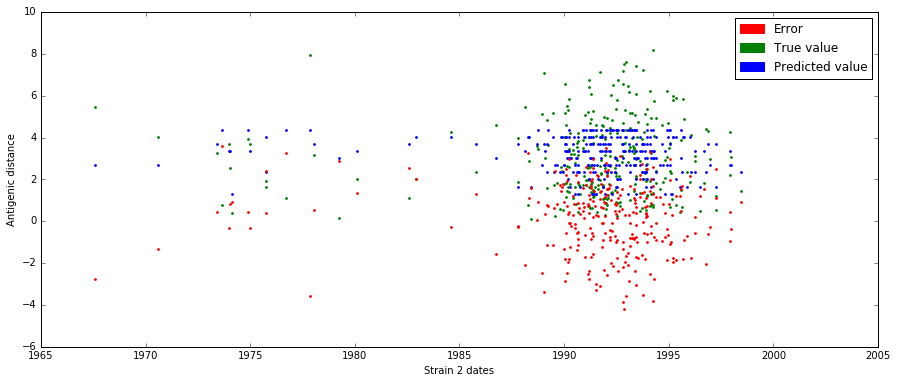

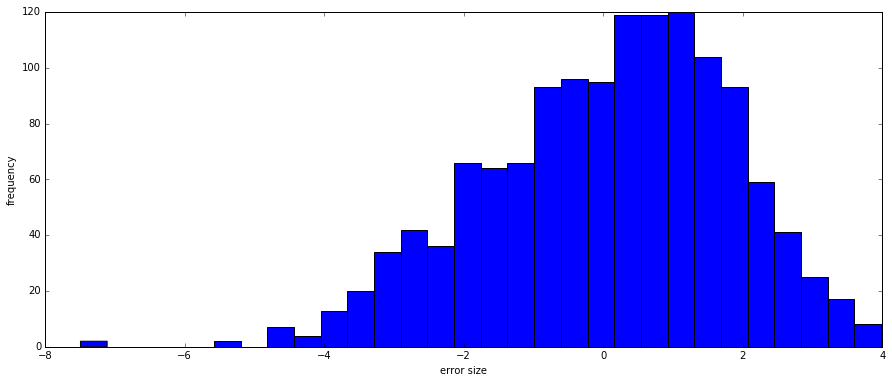

In [25]:
errorplot(ham, Xtest_ham)

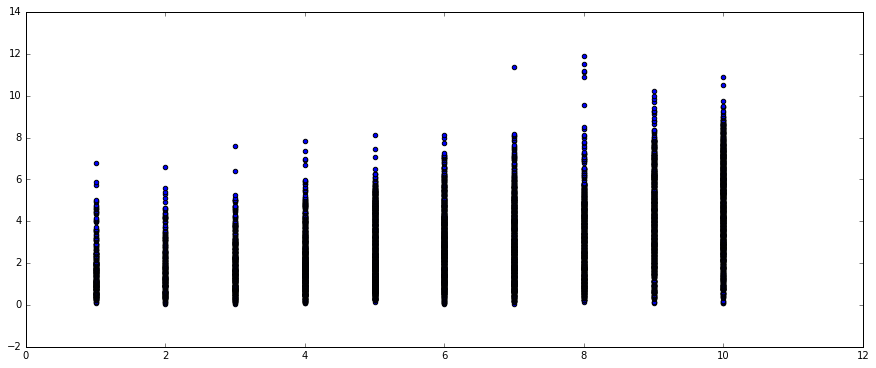

In [26]:
plt.scatter(df['NUM-MUTATIONS'], df['AG-DIST'])

(0, 17)

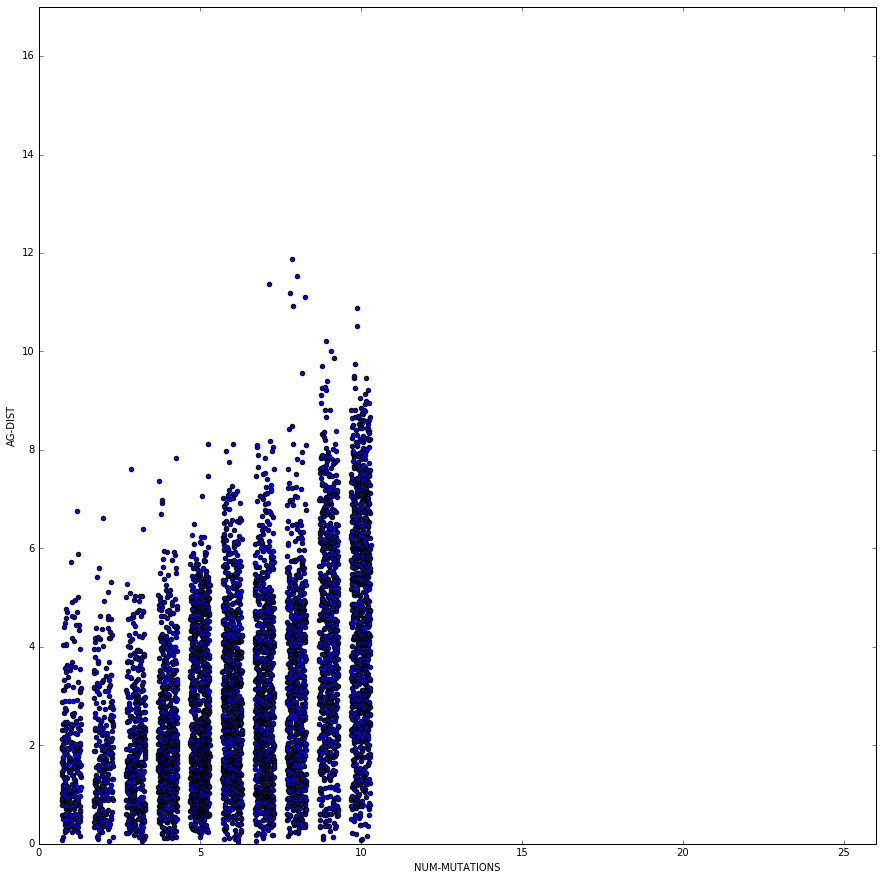

In [27]:
fig_size = [15, 15]
plt.rcParams["figure.figsize"] = fig_size
jitteredHD = df['NUM-MUTATIONS'] + np.random.uniform(-0.3, 0.3, len(df))
plt.xlabel('NUM-MUTATIONS')
plt.ylabel('AG-DIST')
plt.scatter(jitteredHD, df['AG-DIST'])
plt.xlim(0,26)
plt.ylim(0,17)